# High number of transcripts caused by specific tissue or sample size

Reviewers were wondering why so many new transcripts (60%) <br>
"<br>
Moreover, it would be interesting to analyze, **whether the putatively novel transcripts are originating from specific datasets and/or tissues**. The link to the dataset(s) could be made available for unique tissue-transcript combinations.<br>
"<br>
"<br>
How would figure S2 look like if it were corrected by number of analysed tissues?<br>
"<br>


In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np

## More samples more aGPCRs > 0.1/0.5 TPM per tissue?

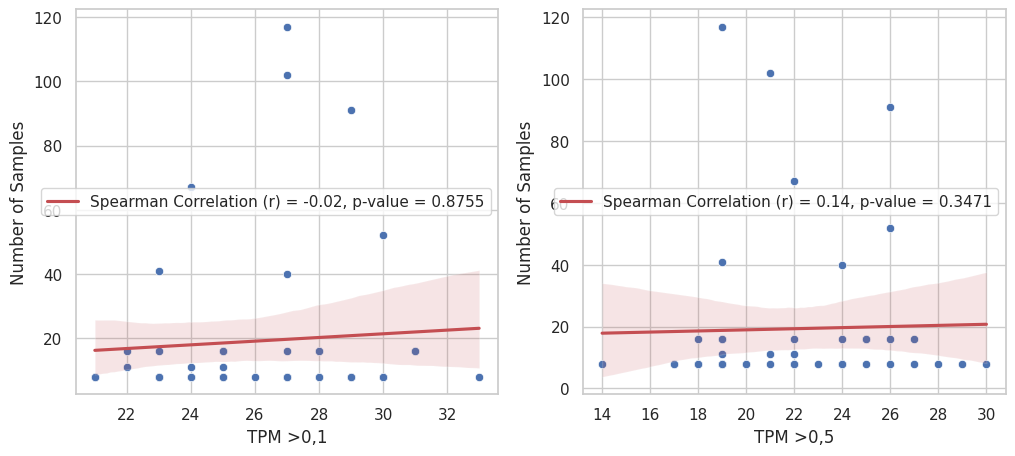

In [54]:
aGPCR_expression = pd.read_csv("Suppl_Table_S6_Expression_analysis.csv", index_col=0)
number_of_samples_per_tissue = pd.read_csv("Suppl_Table_S2_Tissues.csv", index_col=0)
#get row "TPM >0,1" from aGPCR_expression

row_tpm_1 = aGPCR_expression.loc['TPM >0,1']
row_tpm_5 = aGPCR_expression.loc['TPM >0,5']
   

new_index = number_of_samples_per_tissue.index.to_list()

number_of_samples_per_tissue.rename(index=dict(zip(number_of_samples_per_tissue.index, row_tpm_1.index)), inplace=True)

result = pd.concat([row_tpm_1, number_of_samples_per_tissue["Number of Samples"]], axis=1)
result.sort_values(by="TPM >0,1", ascending=False)


# Assuming df is your DataFrame
# Replace 'column1' and 'column2' with your actual column names

# Scatter plot for TPM >0,1
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot 1: TPM >0,1
scatter_plot1 = sns.scatterplot(x='TPM >0,1', y='Number of Samples', data=result, ax=axes[0])

# Calculate and display the Spearman correlation coefficient for TPM >0,1
spearman_corr1, p_value1 = spearmanr(result['TPM >0,1'], result['Number of Samples'])

# Plot the correlation line for TPM >0,1
sns.regplot(x='TPM >0,1', y='Number of Samples', data=result, scatter=False, ax=scatter_plot1, color='r',
            label=f'Spearman Correlation (r) = {spearman_corr1:.2f}, p-value = {p_value1:.4f}')

# Add legend
scatter_plot1.legend()

result = pd.concat([row_tpm_5, number_of_samples_per_tissue["Number of Samples"]], axis=1)
result.sort_values(by="TPM >0,5", ascending=False)

# Plot 2: TPM >0,5
scatter_plot2 = sns.scatterplot(x='TPM >0,5', y='Number of Samples', data=result, ax=axes[1])

# Calculate and display the Spearman correlation coefficient for TPM >0,5
spearman_corr2, p_value2 = spearmanr(result['TPM >0,5'], result['Number of Samples'])

# Plot the correlation line for TPM >0,5
sns.regplot(x='TPM >0,5', y='Number of Samples', data=result, scatter=False, ax=scatter_plot2, color='r',
            label=f'Spearman Correlation (r) = {spearman_corr2:.2f}, p-value = {p_value2:.4f}')

# Add legend
scatter_plot2.legend()

plt.show()

I plotted the number of aGPCRs which sum >0.1TPMs(>0.5TPMs) (in one tissue) vs the number of samples corresponding to the tissue <br>
-> we dont see a correlation that we have a higher number of TPMs if the number of samples contrubing to the tissue is higher too <br>
-> therefore more samples per tissues does not mean higher TPMs per gene <br>

## Per aGPCR: Each tissue vs. number of transcripts
how many of aGPCRs have expression under 0.1TPM

In [115]:
# Provide the path to your Excel file
excel_file_path = 'Suppl_Table_S5_Transcripts_in_tissues.xlsx'

# Read all sheets into a dictionary of DataFrames
all_sheets = pd.read_excel(excel_file_path, sheet_name=None)
aGPCRs_dict = {}
count_dict = {}
count_of_all_NSTRG_transcripts = {}

# Iterate through each sheet
for sheet_name, sheet_df in all_sheets.items():
    if sheet_name == "Index":
        continue
    # if sheet_name != "ADGRC1":
    #     continue #just for save time while testing    

    
    sheed_cleaned = sheet_df.drop(columns=["gene_id","gene_name","length (bp)","start","end","# of exons"])
    columns_to_drop = ["number according to Figure 5", "Median", "Mean","number according to the Figure 1","number according to Figure 3"]
# Iterate through the list and drop columns if they exist
    for column in columns_to_drop:
        if column in sheed_cleaned.columns:
            sheed_cleaned.drop(column, axis=1, inplace=True)
            
    sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
    sheed_cleaned = sheed_cleaned.dropna()
    prefixes_to_keep = ['NSTRG', 'XM', 'XR', 'XP','NM']
    mask = sheed_cleaned['transcript_id'].str.startswith(tuple(prefixes_to_keep)).fillna(False)
    sheed_cleaned = sheed_cleaned[mask]

    tissues = sheed_cleaned.columns[1:]
    
    if not count_dict:
        count_dict = {column: 0 for column in tissues}
        count_of_all_transcripts = {column: 0 for column in tissues}
        count_of_all_NSTRG_transcripts = {column: 0 for column in tissues}
    # sheed_cleaned["over_tissues"] = sheed_cleaned.mean(axis=1)
    sheed_all = sheed_cleaned.drop('transcript_id', axis=1)
    for column in sheed_all.columns:
        count = sheed_all[column].apply(lambda x: 1 if x > 0.01 else 0).sum()
        count_dict[column] = count_dict[column] + count

    df_filtered = sheed_cleaned[sheed_cleaned["transcript_id"].astype(str).str.contains("NSTRG")]
    df_filtered = df_filtered.drop('transcript_id', axis=1)

    for column in df_filtered.columns:
        count = df_filtered[column].apply(lambda x: 1 if x > 0.01 else 0).sum()
        count_of_all_NSTRG_transcripts[column] = count_of_all_NSTRG_transcripts[column] + count
   
    # transcripts = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('(mean)'))]
    # sheed_cleaned = sheed_cleaned.sort_values("over_tissues")
    
    # #### LOW EXPRESSED transcripts
    
    # #calculate the % of transcripts that are under 0.1 TPMs 
    # percentage_below_01 = (sheed_cleaned['over_tissues'] < 0.1).mean() * 100
    # number_01 = (sheed_cleaned['over_tissues'] < 0.1).sum()
    
    # ### NEWLY TRANSCRIPTS
    # # Filter transcripts starting with "NSTRG"
    # nstrg_transcripts = sheed_cleaned[sheed_cleaned['transcript_id'].str.startswith('NSTRG')]
    # # Get the count
    # num_nstrg_transcripts = len(nstrg_transcripts)
    # percentage_nstrg_transcripts = (num_nstrg_transcripts/sheed_cleaned.shape[0])*100

    # aGPCRs_dict[sheet_name] = number_01,percentage_below_01,num_nstrg_transcripts,percentage_nstrg_transcripts
    
#     plt.figure(figsize=(10, 6))
#     plt.scatter(sheed_cleaned["transcript_id"], sheed_cleaned["over_tissues"], color='skyblue')
#     plt.axhline(y=0.1, color='red', linestyle='--', label='Threshold (0.1 TPM)')
#     plt.xlabel('Transcript ID')
#     plt.ylabel('Over Tissues Value')
#     plt.title(sheet_name)
#     plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
#     plt.savefig("output/"+sheet_name+".png")
#     plt.show()
#     plt.clf()


# df = pd.DataFrame.from_dict(aGPCRs_dict)
# df = df.transpose()
# new_col = ["number of transcripts under 0.1 TPM","% of transcipts under 0.1 TPM","number of NSTRG transcripts","% of NSTRG transcripts"]
# df = df.set_axis(new_col, axis=1)
# df.to_csv("low_expressed_and_newly.csv")

count_of_all_NSTRG_transcripts

/tmp/ipykernel_57805/4126106056.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_57805/4126106056.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd)') | sheed_cleaned.columns.str.contains('(%)'))]
/tmp/ipykernel_57805/4126106056.py:25: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  sheed_cleaned = sheed_cleaned.loc[:, ~(sheed_cleaned.columns.str.contains('Unnamed') | sheed_cleaned.columns.str.contains('(sd

{'TPM(mean)brain': 299,
 'TPM(mean)brain opioid': 248,
 'TPM(mean)brain alzheimer': 270,
 'TPM(mean)brain fetal': 255,
 'TPM(mean)brain frontal cortex': 219,
 'TPM(mean)brain parietal cortex': 228,
 'TPM(mean)brain occipital cortex': 256,
 'TPM(mean)brain striatum': 241,
 'TPM(mean)brain stem': 200,
 'TPM(mean)brain cerebellum': 160,
 'TPM(mean)esophagus': 150,
 'TPM(mean)stomach': 110,
 'TPM(mean)small intestine': 171,
 'TPM(mean)duodenum': 188,
 'TPM(mean)jejunum colon': 172,
 'TPM(mean)ileum colon': 185,
 'TPM(mean)colon': 168,
 'TPM(mean)proximal colon': 146,
 'TPM(mean)distal colon': 120,
 'TPM(mean)liver': 156,
 'TPM(mean)pancreas': 87,
 'TPM(mean)kidney': 239,
 'TPM(mean)bladder': 167,
 'TPM(mean)breast': 132,
 'TPM(mean)ovary': 152,
 'TPM(mean)fallopian tube': 212,
 'TPM(mean)uterus': 146,
 'TPM(mean)cervix': 193,
 'TPM(mean)placenta': 140,
 'TPM(mean)prostate': 175,
 'TPM(mean)testicle': 195,
 'TPM(mean)heart': 237,
 'TPM(mean)pericardium': 164,
 'TPM(mean)right atrium heart':

In [172]:
number_of_samples_per_tissue = pd.read_csv("Suppl_Table_S2_Tissues.csv", index_col=0)
number_of_samples_per_tissue = number_of_samples_per_tissue.rename(index={number_of_samples_per_tissue.index[0]: "brain"})# number_of
df_sorted = number_of_samples_per_tissue.sort_values(by='Number of Samples', ascending=False)
sorted_tissues_by_n = df_sorted.index.to_list()
sorted_tissues_by_n

tissues = df_sorted["Number of Samples"]

In [151]:
dict_percentage = {}
for (key, value) in count_of_all_NSTRG_transcripts.items():
    percent = count_dict[key]/(100* count_of_all_NSTRG_transcripts[key])
    dict_percentage[key] = round(percent*1000,2)
dict_percentage

{'brain': 16.56,
 'brain opioid': 17.7,
 'brain alzheimer': 16.37,
 'brain fetal': 16.51,
 'brain frontal cortex': 16.03,
 'brain parietal cortex': 17.32,
 'brain occipital cortex': 16.05,
 'brain striatum': 16.56,
 'brain stem': 16.3,
 'brain cerebellum': 16.31,
 'esophagus': 18.93,
 'stomach': 21.82,
 'small intestine': 16.78,
 'duodenum': 18.03,
 'jejunum colon': 15.52,
 'ileum colon': 16.54,
 'colon': 15.95,
 'proximal colon': 16.23,
 'distal colon': 16.25,
 'liver': 16.47,
 'pancreas': 20.8,
 'kidney': 18.41,
 'bladder': 18.38,
 'breast': 17.73,
 'ovary': 15.99,
 'fallopian tube': 17.64,
 'uterus': 16.23,
 'cervix': 17.36,
 'placenta': 17.07,
 'prostate': 18.63,
 'testicle': 18.21,
 'heart': 16.08,
 'pericardium': 17.56,
 'right atrium heart': 16.81,
 'left atruim': 17.04,
 'right ventricle heart': 17.39,
 'left ventricle heart': 16.77,
 'vena cava': 17.02,
 'trachea': 18.59,
 'lung': 17.56,
 'thymus': 18.6,
 'spleen': 16.42,
 'lymph node': 16.87,
 'thyroid': 20.86,
 'adrenal': 16

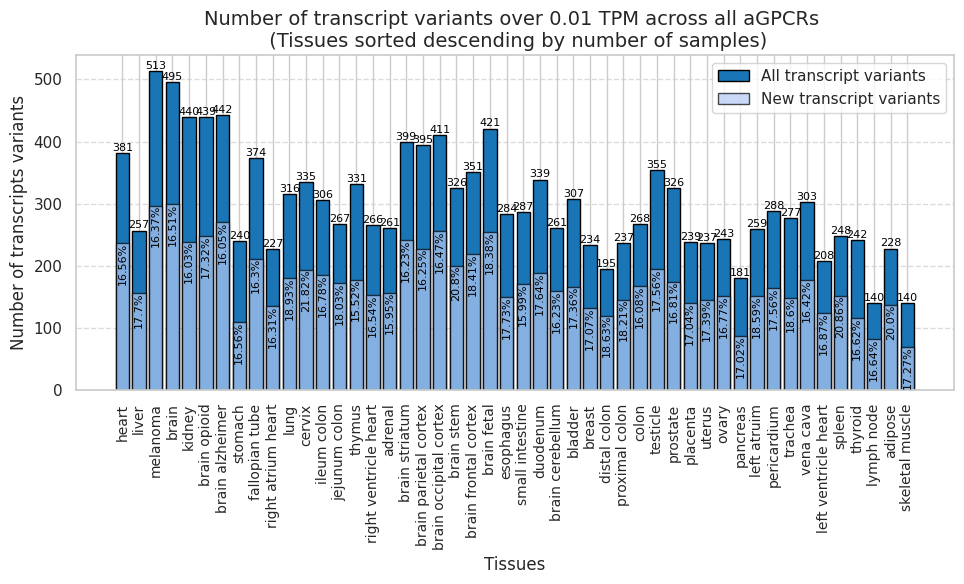

In [167]:
count_dict = {key.replace("TPM(mean)", ""): value for key, value in count_dict.items()}
count_of_all_NSTRG_transcripts =  {key.replace("TPM(mean)", ""): value for key, value in count_of_all_NSTRG_transcripts.items()}

count_dict_sorted = {key: count_dict[key] for key in sorted_tissues_by_n}
count_of_all_NSTRG_transcripts_sorted = {key: count_of_all_NSTRG_transcripts[key] for key in sorted_tissues_by_n}

# Extract keys and values from the dictionary
labels = list(count_dict_sorted.keys())
values = list(count_dict_sorted.values())
values_NSTRG = list(count_of_all_NSTRG_transcripts_sorted.values())

# Create a bar plot with additional styling
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Create the bar plot
bar_color = '#1975B5' 
bar_color_NSTRG = '#B3C9F4'
line_color = "red"

# Create the bar plot
plt.bar(labels, values, color=bar_color, edgecolor='black', label='All transcript variants')
plt.bar(labels, values_NSTRG, color=bar_color_NSTRG, edgecolor='black', label='New transcript variants', alpha=0.7)

# Rotate x-axis labels by -45 degrees and set font size
plt.xticks(rotation=90, fontsize=10)

# Add labels and title
plt.xlabel('Tissues', fontsize=12)
plt.ylabel('Number of transcripts variants', fontsize=12)
plt.title('Number of transcript variants over 0.01 TPM across all aGPCRs \n (Tissues sorted descending by number of samples)', fontsize=14)

# Add grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value annotations on top of the bars
for label, value in zip(labels, values):
    plt.text(label, value + 0.1, str(value), ha='center', va='bottom', fontsize=8, color='black')
    
percentages = list(dict_percentage.values())
for label, value, number in zip(labels, values_NSTRG, percentages):
    plt.text(label, value + 1, f"{number}%", ha='center', va='top', fontsize=8, color='black', rotation=90)

# Display the plot
plt.legend()
plt.tight_layout(rect=(0.02, 0.02, 1, 1.02))
plt.savefig('number_transcripts_per_tissue.png', dpi=300)
plt.show()

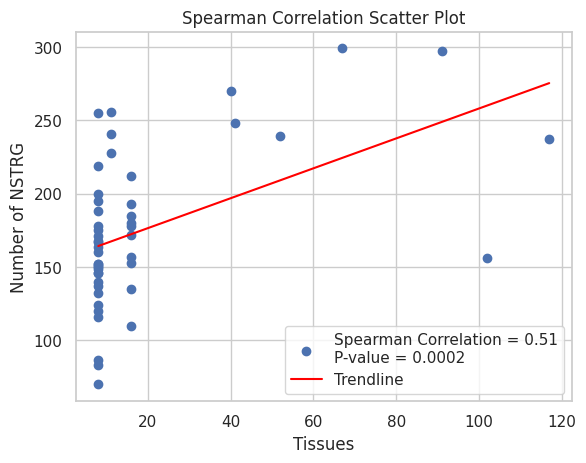

In [180]:
values_NSTRG

corr_coefficient, p_value = spearmanr(tissues, values_NSTRG)

# Scatter plot
plt.scatter(tissues, values_NSTRG, label=f"Spearman Correlation = {corr_coefficient:.2f}\nP-value = {p_value:.4f}")

# Add a trendline (correlation line)
z = np.polyfit(tissues, values_NSTRG, 1)
p = np.poly1d(z)
plt.plot(tissues, p(tissues), color='red', label='Trendline')

# Add labels and title
plt.xlabel('Tissues')
plt.ylabel('Number of NSTRG')
plt.title('Spearman Correlation Scatter Plot')

# Add a grid for better readability
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

In [5]:
df

,number of transcripts under 0.1 TPM,% of transcipts under 0.1 TPM,number of NSTRG transcripts,% of NSTRG transcripts
ADGRA1,2.0,33.333333,2.0,33.333333
ADGRA2,1.0,20.000000,1.0,20.000000
ADGRA3,1.0,10.000000,6.0,60.000000
ADGRB1,19.0,48.717949,30.0,76.923077
ADGRB2,28.0,52.830189,31.0,58.490566
ADGRB3,1.0,14.285714,6.0,85.714286
ADGRC1,3.0,16.666667,13.0,72.222222
ADGRC2,4.0,57.142857,6.0,85.714286
ADGRC3,6.0,54.545455,10.0,90.909091
ADGRD1,0.0,0.000000,10.0,45.454545
